In [3]:
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Concatenate
import matplotlib.pyplot as plt


In [4]:
# Constants
TOP_25_STOCKS = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 
                 'TSLA', 'GOOG', 'BRK-B', 'META', 'UNH', 
                 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 
                 'PG', 'MA', 'AVGO', 'HD', 'CVX', 
                 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']


In [5]:
# Encoding tickers
label_encoder = LabelEncoder()
TICKERS_ENCODED = label_encoder.fit_transform(TOP_25_STOCKS)
TICKERS_ONEHOT = to_categorical(TICKERS_ENCODED)

In [15]:
# Function to load data
def load_data(directory, stocks):
    all_data = []
    for stock in stocks:
        if "Train" in directory:
            file_path = os.path.join(directory, f'Train_{stock}.csv')
        else:
            file_path = os.path.join(directory, f'Test_{stock}.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            all_data.append(data)
    return pd.concat(all_data)

In [16]:
# Load training and testing data
train_directory = 'TrainStockData'
test_directory = 'TestStockData'

train_data = load_data(train_directory, TOP_25_STOCKS)
test_data = load_data(test_directory, TOP_25_STOCKS)
train_data

,Date,Ticker,Close,Volume
0,2012-01-03,AAPL,14.686785,302258796
1,2012-01-04,AAPL,14.765714,260244432
2,2012-01-05,AAPL,14.929642,271267220
3,2012-01-06,AAPL,15.085714,318385648
4,2012-01-09,AAPL,15.061785,394023168
...,...,...,...,...
2763,2022-12-23,ADBE,338.450012,1629800
2764,2022-12-27,ADBE,335.089996,1464300
2765,2022-12-28,ADBE,328.329987,1672100
2766,2022-12-29,ADBE,337.579987,1793100


In [19]:
def preprocess_data(data, label_encoder, time_steps=50):
    # Ensure Date is datetime
    data['Date'] = pd.to_datetime(data['Date'])
    # Sort by Date
    data = data.sort_values('Date')
    
    # Encode tickers
    data['Ticker_Encoded'] = label_encoder.transform(data['Ticker'])
    
    # Initialize lists for data
    X_50 = []
    X_200 = []
    X_vol = []
    X_ticker = []
    y = []
    
    for i in range(len(data) - time_steps*4):
        # Extract sequences
        X_50.append(data['Close'].values[i:i+time_steps])
        X_200.append(data['Close'].values[i:i+time_steps*4])  # Longer term trends
        X_vol.append(data['Volume'].values[i:i+time_steps])
        X_ticker.append(TICKERS_ONEHOT[data['Ticker_Encoded'].values[i+time_steps]])
        y.append(data['Close'].values[i+time_steps:i+time_steps+3])  # Predict next day, 3 days, 1 week
    
    X_50_arr = np.array(X_50)
    X_200_arr = np.array(X_200)
    X_vol_arr = np.array(X_vol)
    X_ticker_arr = np.array(X_ticker)

    return (np.array(X_50), np.array(X_200), np.array(X_vol), np.array(X_ticker)), np.array(y)


In [20]:
# Make sure the ticker input is correctly included in the training
X_train, y_train = preprocess_data(train_data, label_encoder)
X_test, y_test = preprocess_data(test_data, label_encoder)

# Reshape data
X_train_50, X_train_200, X_train_vol, X_train_ticker = X_train
X_test_50, X_test_200, X_test_vol, X_test_ticker = X_test

X_train_50 = X_train_50.reshape((X_train_50.shape[0], X_train_50.shape[1], 1))
X_train_200 = X_train_200.reshape((X_train_200.shape[0], X_train_200.shape[1], 1))
X_train_vol = X_train_vol.reshape((X_train_vol.shape[0], X_train_vol.shape[1], 1))
X_test_50 = X_test_50.reshape((X_test_50.shape[0], X_test_50.shape[1], 1))
X_test_200 = X_test_200.reshape((X_test_200.shape[0], X_test_200.shape[1], 1))
X_test_vol = X_test_vol.reshape((X_test_vol.shape[0], X_test_vol.shape[1], 1))

# Ensure ticker inputs are correct
print("Ticker inputs shape:", X_train_ticker.shape)

# Define model inputs
input_50 = Input(shape=(50, 1))
input_200 = Input(shape=(200, 1))
input_vol = Input(shape=(50, 1))
input_ticker = Input(shape=(len(TICKERS_ONEHOT[0]),))  # One-hot encoded ticker vector length

# LSTM layers for sequential data
x_50 = LSTM(50, return_sequences=True)(input_50)
x_50 = LSTM(50, return_sequences=False)(x_50)

x_200 = LSTM(50, return_sequences=True)(input_200)
x_200 = LSTM(50, return_sequences=False)(x_200)

x_vol = LSTM(50, return_sequences=True)(input_vol)
x_vol = LSTM(50, return_sequences=False)(x_vol)

# Dense layers for ticker
x_ticker = Dense(10, activation='relu')(input_ticker)

# Concatenate all processed inputs
x = Concatenate()([x_50, x_200, x_vol, x_ticker])
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(3)(x)  # Predict next day, 3 days, and 1 week closing prices

# Create the model
model = Model(inputs=[input_50, input_200, input_vol, input_ticker], outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()


Ticker inputs shape: (68095, 25)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 50)    │     10,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 200, 50)   │     10,400 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 50, 50)    │     10,400 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 50)        │     20,200 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        260 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ lstm_5[0][0],     │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      8,050 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        153 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,263 (391.65 KB)

 Trainable params: 100,263 (391.65 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(
    [X_train_50, X_train_200, X_train_vol, X_train_ticker], y_train,
    epochs=10, batch_size=32, validation_data=([X_test_50, X_test_200, X_test_vol, X_test_ticker], y_test)
)

Epoch 1/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 201s 93ms/step - loss: 8915.3350 - val_loss: 15245.0654
Epoch 2/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 218s 102ms/step - loss: 4872.4946 - val_loss: 14342.7207
Epoch 3/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - loss: 4671.7231 - val_loss: 14074.9053
Epoch 4/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 208s 98ms/step - loss: 4668.5010 - val_loss: 14010.1357
Epoch 5/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 203s 95ms/step - loss: 4502.4312 - val_loss: 14042.6328
Epoch 6/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 203s 95ms/step - loss: 4487.9209 - val_loss: 13917.8711
Epoch 7/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 209s 98ms/step - loss: 4489.6196 - val_loss: 13861.2920
Epoch 8/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 215s 101ms/step - loss: 4472.8130 - val_loss: 13893.1543
Epoch 9/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 1893s 890ms/step - loss: 4465.2632 - val_loss: 14260.4590
Epoch 10/10
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - loss: 4416.1523 - val_loss: 13855.9287


255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


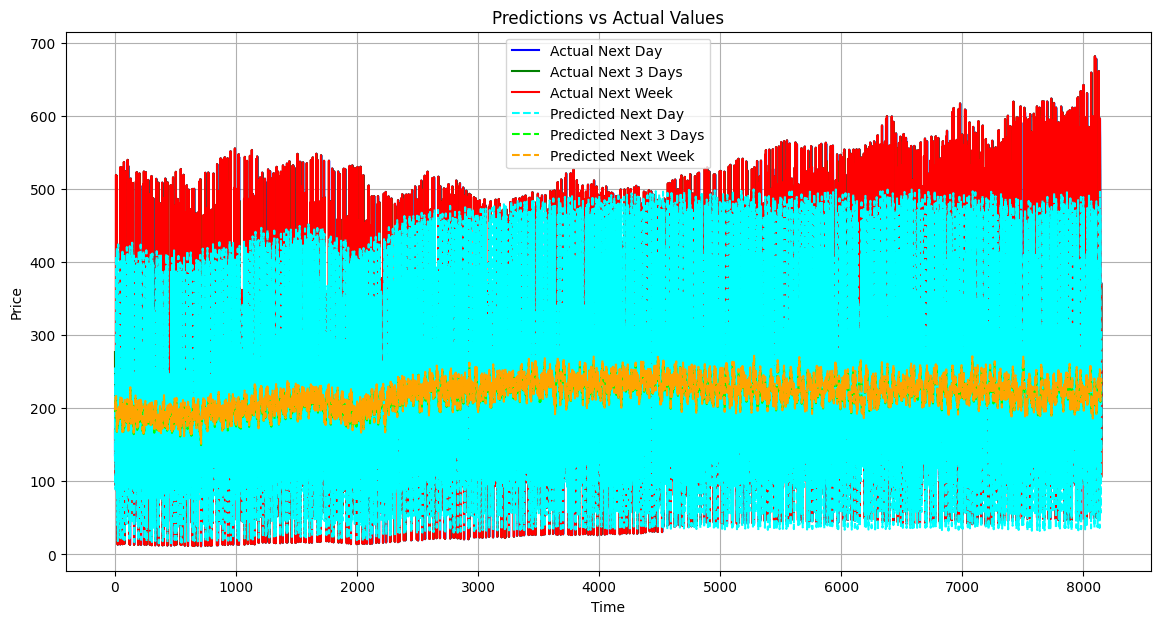

In [22]:
# Generate predictions for the test set
predictions = model.predict([X_test_50, X_test_200, X_test_vol, X_test_ticker])

# Extract actual values for plotting
actual_values = y_test

# Plotting
def plot_predictions_vs_actual(predictions, actual_values, title):
    plt.figure(figsize=(14, 7))
    
    # Plot actual values
    plt.plot(actual_values[:, 0], color='blue', label='Actual Next Day')
    plt.plot(actual_values[:, 1], color='green', label='Actual Next 3 Days')
    plt.plot(actual_values[:, 2], color='red', label='Actual Next Week')
    
    # Plot predicted values
    plt.plot(predictions[:, 0], color='cyan', linestyle='dashed', label='Predicted Next Day')
    plt.plot(predictions[:, 1], color='lime', linestyle='dashed', label='Predicted Next 3 Days')
    plt.plot(predictions[:, 2], color='orange', linestyle='dashed', label='Predicted Next Week')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions vs actual values for the next day, next 3 days, and next week
plot_predictions_vs_actual(predictions, actual_values, 'Predictions vs Actual Values')